# IDM Engineering - March Madness Machine Learning - 2020

Welcome to the first 

## Library Imports

asdf

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

import seaborn as sns

import os
import pkg_resources

from binarytree import Node
# import matplotlib.pyplot as plt # for notebook usage
# import numpy as np # for notebook usage
import pandas as pd
from PIL import Image, ImageDraw

import slot_coordinates
import matplotlib.pyplot as plt


import statsmodels.api as sm

import dataWranglingFunctions as DWF



In [2]:
cwd = os.getcwd()

## Data Wrangling

The intention of the data wrangling section is to create a dataframe of our target variable (result) and the given factors.

First, let's see what format the data is in that we currently have.

In [3]:
# import tournament results and filter to only years > target year. 
tourney_cresults = pd.read_csv(cwd + '/data/MNCAATourneyCompactResults.csv')
seeds = pd.read_csv(cwd + '/data/MNCAATourneySeeds.csv')
season_dresults = pd.read_csv(cwd +'/data/MRegularSeasonDetailedResults.csv')

Tourney results is the results of every tournament game. 

In [4]:
tourney_cresults.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT
0    1985     136     1116      63     1234      54    N      0
1    1985     136     1120      59     1345      58    N      0
2    1985     136     1207      68     1250      43    N      0
3    1985     136     1229      58     1425      55    N      0
4    1985     136     1242      49     1325      38    N      0

Seeds is the seed team ID for each season. 

In [5]:
seeds.head()

Season Seed  TeamID
0    1985  W01    1207
1    1985  W02    1210
2    1985  W03    1228
3    1985  W04    1260
4    1985  W05    1374

season_dresults is the regular season results, including every statistic that we have access to. 

In [6]:
season_dresults.head()

Season  DayNum  WTeamID  WScore  LTeamID  LScore WLoc  NumOT  WFGM  WFGA  \
0    2003      10     1104      68     1328      62    N      0    27    58   
1    2003      10     1272      70     1393      63    N      0    26    62   
2    2003      11     1266      73     1437      61    N      0    24    58   
3    2003      11     1296      56     1457      50    N      0    18    38   
4    2003      11     1400      77     1208      71    N      0    30    61   

   ...  LFGA3  LFTM  LFTA  LOR  LDR  LAst  LTO  LStl  LBlk  LPF  
0  ...     10    16    22   10   22     8   18     9     2   20  
1  ...     24     9    20   20   25     7   12     8     6   16  
2  ...     26    14    23   31   22     9   12     2     5   23  
3  ...     22     8    15   17   20     9   19     4     3   23  
4  ...     16    17    27   21   15    12   10     7     1   14  

[5 rows x 34 columns]

In [7]:
# Field descriptions:
# deltaSeed: difference in team's seeds
# deltaMO: difference in team's Massey Ordinals on day 128
# deltaWinPct: difference in the team's winning percentage 
# deltaPointsFor: difference in the average points scored per game
# deltaPointsAgainst: difference in the average points scored agains the teams
# deltaFGM: difference in the field goals made per game
# deltaFGA: difference in the field goals attempted per game
# deltaFGM3: difference in 3 point fields goals made per game
# deltaFGA3: difference in the 3 points fields goals attempted per game
# deltaFTM: difference in free throws made per game
# deltaFTA: difference in free throws attempted per game
# deltaOR: difference in offence rebounds per game
# deltaDR: difference in defensive rebounds per game
# deltaAst: difference in assists per game
# deltaTO: difference in turnovers per game
# deltaStl: difference in steals per game
# deltaBlk: difference in blocks per game
# deltaPF: difference in personal fouls per game

In [8]:
targetYear = 2003

In [9]:
tourney_cresults = tourney_cresults.loc[tourney_cresults['Season'] >= targetYear]

The first thing we are going to do is create a training set of data. Lets start with an empty dataframe.

In [10]:
# create the training data set. Team 1 is winner, Team 2 is loser. 
training_set = pd.DataFrame()
training_set.head()

Empty DataFrame
Columns: []
Index: []

Now, what are some things we want in our training set? What is our target variable? Result, so probably want that. How about Team 1, Team 2, and season as well. 

In [11]:
training_set['Result'] = np.random.randint(0,2,len(tourney_cresults.index))
training_set['Season'] = tourney_cresults['Season'].values
training_set['Team1'] = training_set['Result'].values * tourney_cresults['WTeamID'].values + (1-training_set['Result'].values) * tourney_cresults['LTeamID'].values 
training_set['Team2'] = (1-training_set['Result'].values) * tourney_cresults['WTeamID'].values + training_set['Result'].values * tourney_cresults['LTeamID'].values
training_set.head()

Result  Season  Team1  Team2
0       1    2003   1421   1411
1       1    2003   1112   1436
2       1    2003   1113   1272
3       1    2003   1141   1166
4       1    2003   1143   1301

So now we have a dataset of every team that played against each other, who the winner was. Neat!

What are some other pieces of information we would like in our training data? One of the most obvious things would be the difference in the seeds that year. 

The first thing 

In [12]:
seeds['Seed'] =  pd.to_numeric(seeds['Seed'].str[1:3], downcast='integer',errors='coerce')

In [16]:
def delta_seed(row):
    cond = (seeds['Season'] == row['Season'])
    return seeds[cond & (seeds['TeamID'] == row['Team1'])]['Seed'].iloc[0] - seeds[cond & (seeds['TeamID'] == row['Team2'])]['Seed'].iloc[0]

# function to, given a row, calculate what the difference between the two seeds was. 
#Function to look up 
def delta_winPct(row):
    cond1 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team1'])
    cond2 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team2'])
    return (record[cond1]['wins']/record[cond1]['games']).mean() - (record[cond2]['wins']/record[cond2]['games']).mean()

def get_points_against(row):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'LScore'
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'WScore'
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum() 
    return retVal

def get_points_for(row):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'WScore'
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'LScore'
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum() 
    return retVal

def get_remaining_stats(row, field):
    wcond = (dfW['Season'] == row['Season']) & (dfW['WTeamID'] == row['WTeamID']) 
    fld1 = 'W' + field
    lcond = (dfL['Season'] == row['Season']) & (dfL['LTeamID'] == row['WTeamID']) 
    fld2 = 'L'+ field
    retVal = dfW[wcond][fld1].sum()
    if len(dfL[lcond][fld2]) > 0:
        retVal = retVal + dfL[lcond][fld2].sum()
    return retVal

def delta_stat(row, field):
    cond1 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team1'])
    cond2 = (record['Season'] == row['Season']) & (record['WTeamID'] == row['Team2'])
    return (record[cond1][field]/record[cond1]['games']).mean() - (record[cond2][field]/record[cond2]['games']).mean()
  

In [17]:
#  Calculate Delta Seeds
training_set['deltaSeed'] = training_set.apply(delta_seed,axis=1)
training_set.head()

Result  Season  Team1  Team2  deltaSeed
0       1    2003   1421   1411          0
1       1    2003   1112   1436        -15
2       1    2003   1113   1272          3
3       1    2003   1141   1166          5
4       1    2003   1143   1301         -1

Next, lets add what the difference in the teams records are. That is usually a good indication of how good a team is! To do this, first lets build a dataframe of every teams wins, losses, and how many games they played. 

In [18]:
# Calculate win pct
record = pd.DataFrame({'wins': season_dresults.groupby(['Season','WTeamID']).size()}).reset_index();
losses = pd.DataFrame({'losses': season_dresults.groupby(['Season','LTeamID']).size()}).reset_index();

record = record.merge(losses, how='outer', left_on=['Season','WTeamID'], right_on=['Season','LTeamID'])
record = record.fillna(0)
record['games'] = record['wins'] + record['losses']

In [19]:
record.head()

Season  WTeamID  wins  LTeamID  losses  games
0    2003   1102.0  12.0   1102.0    16.0   28.0
1    2003   1103.0  13.0   1103.0    14.0   27.0
2    2003   1104.0  17.0   1104.0    11.0   28.0
3    2003   1105.0   7.0   1105.0    19.0   26.0
4    2003   1106.0  13.0   1106.0    15.0   28.0

Now, we can use our function to calculate the win percentage difference of the two teams that play each other and store it to the training_set dataframe. 

Now, in order to help calculate some of the next pieces of information, it is helpful to create a dataframe of both winners and losers. Don't worry about too much, just know that they are needed for our functions.

In [20]:
# create dataframes of both winners and losers
dfW = season_dresults.groupby(['Season','WTeamID']).sum().reset_index()
dfL = season_dresults.groupby(['Season','LTeamID']).sum().reset_index()

In [21]:
# add points for and points against data
record['PointsFor'] = record.apply(get_points_for, axis=1)
record['PointsAgainst'] = record.apply(get_points_against, axis=1)

In [22]:
record.head()

Season  WTeamID  wins  LTeamID  losses  games  PointsFor  PointsAgainst
0    2003   1102.0  12.0   1102.0    16.0   28.0       1603           1596
1    2003   1103.0  13.0   1103.0    14.0   27.0       2127           2110
2    2003   1104.0  17.0   1104.0    11.0   28.0       1940           1820
3    2003   1105.0   7.0   1105.0    19.0   26.0       1866           1993
4    2003   1106.0  13.0   1106.0    15.0   28.0       1781           1785

Lets go ahead and pull in all of the other stats into our records dataframe. We will make it a for loop to speed it up. - Cut to slides here

In [23]:
cols = ['FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    print("Processing",col)
    record[col] = record.apply(get_remaining_stats, args=(col,), axis=1)

#record['FGprct'] = record['FGM'] / record['FGA']  

Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF


In [24]:
record.head()

Season  WTeamID  wins  LTeamID  losses  games  PointsFor  PointsAgainst  \
0    2003   1102.0  12.0   1102.0    16.0   28.0       1603           1596   
1    2003   1103.0  13.0   1103.0    14.0   27.0       2127           2110   
2    2003   1104.0  17.0   1104.0    11.0   28.0       1940           1820   
3    2003   1105.0   7.0   1105.0    19.0   26.0       1866           1993   
4    2003   1106.0  13.0   1106.0    15.0   28.0       1781           1785   

   FGM   FGA  ...  FGA3  FTM  FTA   OR   DR  Ast   TO  Stl  Blk   PF  
0  536  1114  ...   583  312  479  117  471  364  320  167   50  525  
1  733  1508  ...   434  514  698  264  538  411  341  196   63  536  
2  673  1601  ...   556  416  586  380  670  339  372  185  106  505  
3  634  1602  ...   540  401  568  351  601  378  485  242   54  526  
4  656  1548  ...   494  298  461  344  668  327  477  234   88  509  

[5 rows x 21 columns]

In addition to extracting features from existing data, we could also create our own features by  performing calculations on the data! Let's do an easy one, field goal percentage. 

In [25]:
record['FGprct'] = record['FGM'] / record['FGA']  
record.head()

Season  WTeamID  wins  LTeamID  losses  games  PointsFor  PointsAgainst  \
0    2003   1102.0  12.0   1102.0    16.0   28.0       1603           1596   
1    2003   1103.0  13.0   1103.0    14.0   27.0       2127           2110   
2    2003   1104.0  17.0   1104.0    11.0   28.0       1940           1820   
3    2003   1105.0   7.0   1105.0    19.0   26.0       1866           1993   
4    2003   1106.0  13.0   1106.0    15.0   28.0       1781           1785   

   FGM   FGA  ...  FTM  FTA   OR   DR  Ast   TO  Stl  Blk   PF    FGprct  
0  536  1114  ...  312  479  117  471  364  320  167   50  525  0.481149  
1  733  1508  ...  514  698  264  538  411  341  196   63  536  0.486074  
2  673  1601  ...  416  586  380  670  339  372  185  106  505  0.420362  
3  634  1602  ...  401  568  351  601  378  485  242   54  526  0.395755  
4  656  1548  ...  298  461  344  668  327  477  234   88  509  0.423773  

[5 rows x 22 columns]

You can see we have succesfully added the column FGprct to our dataframe!

Now, to get all of this good data from records into a format for our training set. What is it we are really after? In reality, it would be really hard to tell who would win a game based off of just the raw data. But what WOULD be useful, is the difference in raw data between the two teams. 

To get this, we can run our helper function and put all of the results in the training set dataframe.

In [26]:
training_set.head()

Result  Season  Team1  Team2  deltaSeed
0       1    2003   1421   1411          0
1       1    2003   1112   1436        -15
2       1    2003   1113   1272          3
3       1    2003   1141   1166          5
4       1    2003   1143   1301         -1

In [27]:
cols = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    print("Processing",col)
    training_set['delta' + col] = training_set.apply(delta_stat,args=(col,),axis=1)

Processing PointsFor
Processing PointsAgainst
Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF


In [40]:
training_set['deltaWinPct'] = training_set.apply(delta_winPct,axis=1)

In [41]:
training_set.head()

Result  Season  Team1  Team2  deltaSeed  deltaPointsFor  \
0       1    2003   1421   1411          0       -1.593103   
1       1    2003   1112   1436        -15       17.421182   
2       1    2003   1113   1272          3        1.448276   
3       1    2003   1141   1166          5        0.102403   
4       1    2003   1143   1301         -1        2.082759   

   deltaPointsAgainst  deltaFGM  deltaFGA  deltaFGM3  ...  deltaFTM  deltaFTA  \
0            7.614943 -0.354023  1.526437   0.549425  ... -1.434483 -7.135632   
1            7.112069  5.493842  9.852217   1.759852  ...  4.673645  5.448276   
2            3.344828  0.931034 -3.103448  -3.000000  ...  2.586207  3.310345   
3            8.908046 -2.076280 -4.764890  -1.142111  ...  5.397074  5.142111   
4            1.758621  3.011494  5.390805  -1.552874  ... -2.387356 -0.949425   

    deltaOR   deltaDR  deltaAst   deltaTO  deltaStl  deltaBlk   deltaPF  \
0 -0.890805 -1.627586 -1.165517  0.973563  0.635632  0.766667  0.803448   
1  2.213054  1.918719  3.435961  0.716749  1.602217  1.248768  1.853448   
2 -0.379310 -2.655172 -1.068966  0.206897 -2.172414 -0.827586  0.655172   
3 -0.292581  0.094044 -1.197492  4.877743 -1.290491 -0.454545  3.692790   
4  1.508046  2.345977  1.333333 -0.027586 -1.214943 -0.273563 -1.563218   

   deltaWinPct  
0    -0.151724  
1     0.237685  
2    -0.172414  
3    -0.085684  
4     0.124138  

[5 rows x 21 columns]

Pandas has a ton of built in helper function to help make sense of your data. For instance, stats on all of our columns. 

In [42]:
training_set.describe()

Result       Season        Team1        Team2    deltaSeed  \
count  1115.000000  1115.000000  1115.000000  1115.000000  1115.000000   
mean      0.508520  2011.096861  1296.808072  1293.026009    -0.020628   
std       0.500152     4.896921   106.000783   102.383052     7.464490   
min       0.000000  2003.000000  1102.000000  1101.000000   -15.000000   
25%       0.000000  2007.000000  1210.000000  1211.000000    -5.000000   
50%       1.000000  2011.000000  1292.000000  1281.000000     0.000000   
75%       1.000000  2015.000000  1397.000000  1388.000000     5.000000   
max       1.000000  2019.000000  1462.000000  1463.000000    15.000000   

       deltaPointsFor  deltaPointsAgainst     deltaFGM     deltaFGA  \
count     1115.000000         1115.000000  1115.000000  1115.000000   
mean         0.041289            0.090903     0.003840     0.079473   
std          7.293706            6.407985     2.914911     4.878282   
min        -21.643382          -19.145650    -8.602941   -17.404412   
25%         -4.778176           -4.311553    -2.048162    -3.316206   
50%         -0.115126            0.242424    -0.017137     0.205819   
75%          4.909537            4.372524     1.972040     3.278003   
max         22.892857           25.035714     9.357143    22.071429   

         deltaFGM3  ...     deltaFTM     deltaFTA      deltaOR      deltaDR  \
count  1115.000000  ...  1115.000000  1115.000000  1115.000000  1115.000000   
mean      0.017859  ...     0.015750     0.052737     0.057474    -0.033294   
std       1.804910  ...     2.708491     3.659228     2.561979     2.563831   
min      -6.007315  ...    -7.731034   -10.827586    -7.924632    -9.010776   
25%      -1.171388  ...    -1.800922    -2.210243    -1.636364    -1.776806   
50%       0.023674  ...    -0.133690    -0.061179     0.110991    -0.024621   
75%       1.234598  ...     1.872480     2.506712     1.784564     1.604653   
max       6.062500  ...     8.059629    10.719453     9.214286     9.285714   

          deltaAst      deltaTO     deltaStl     deltaBlk      deltaPF  \
count  1115.000000  1115.000000  1115.000000  1115.000000  1115.000000   
mean     -0.038755     0.036580     0.033612     0.090286     0.028344   
std       2.597900     2.070041     1.851689     1.853901     2.533175   
min      -7.811553    -7.448276    -6.283681    -5.860606    -7.896552   
25%      -1.771163    -1.318015    -1.218750    -1.098556    -1.688419   
50%      -0.104464     0.000000     0.032977     0.014778    -0.016544   
75%       1.750535     1.377261     1.209722     1.304545     1.828677   
max       9.220143     7.666667     6.090133     6.752688     7.256303   

       deltaWinPct  
count  1115.000000  
mean     -0.003190  
std       0.144460  
min      -0.491657  
25%      -0.099432  
50%      -0.006629  
75%       0.084360  
max       0.633333  

[8 rows x 21 columns]

We are in really good shape at this point to start exploring our data in the next section!

In [43]:
training_set.to_csv("training_set.csv", index=False)

In [44]:
training_set = pd.read_csv("training_set.csv")

## Data Analysis

This is where the bulk of the work in machine learning takes place. As you can see, it can be very time consuming to get data into a presentable format. Where the real magic happens is determining what to do with that data once you have it. 

There are several libraries that we will explore to help see the relationships between your data. It is very important to get a good sense of how your features are related to the result before you try to build a model. 

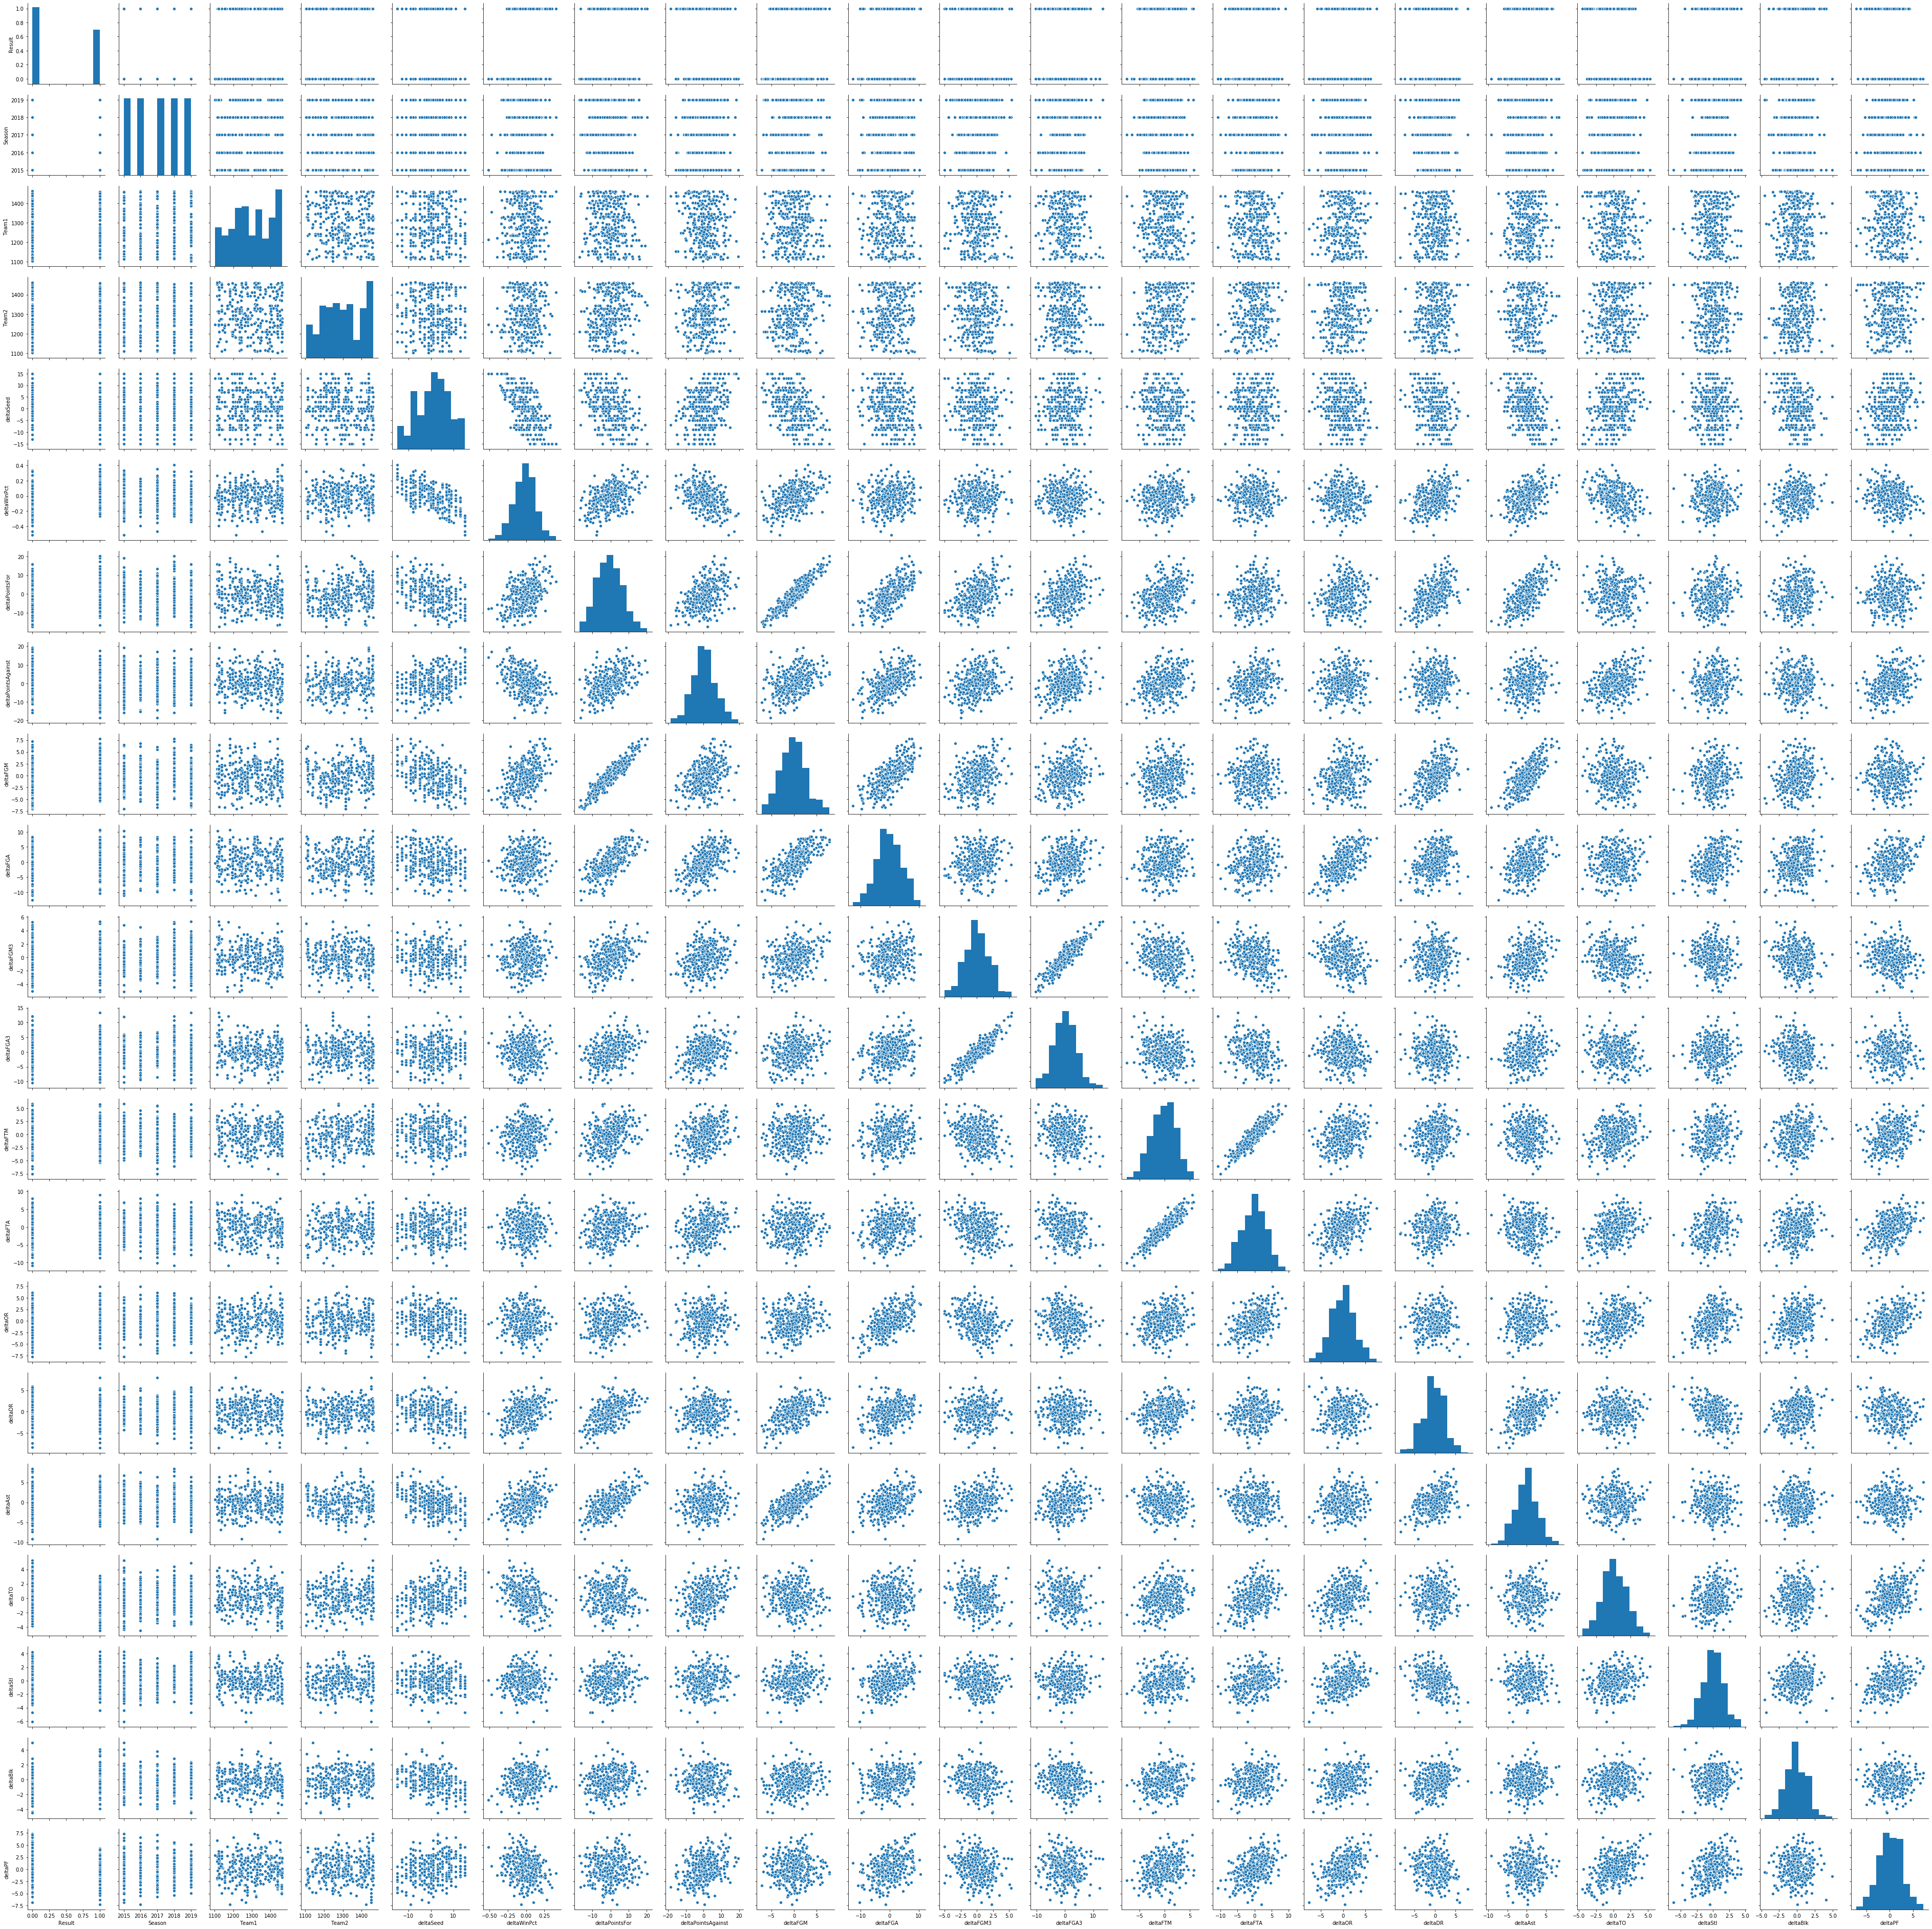

In [35]:
sns.pairplot(data = training_set)

Whew..... thats a lot of data. We have some work to do. 

A very simple tool I like to use to get started is the correlation tool. This lets you see which data is correlated with each other. 

In [32]:
correlation = training_set.corr()

So what did we just do? Well, if we graph a heatmap, you can see that we were able to determine how all variables are linearly related to each other, and visually quickly undertand this relationship. 

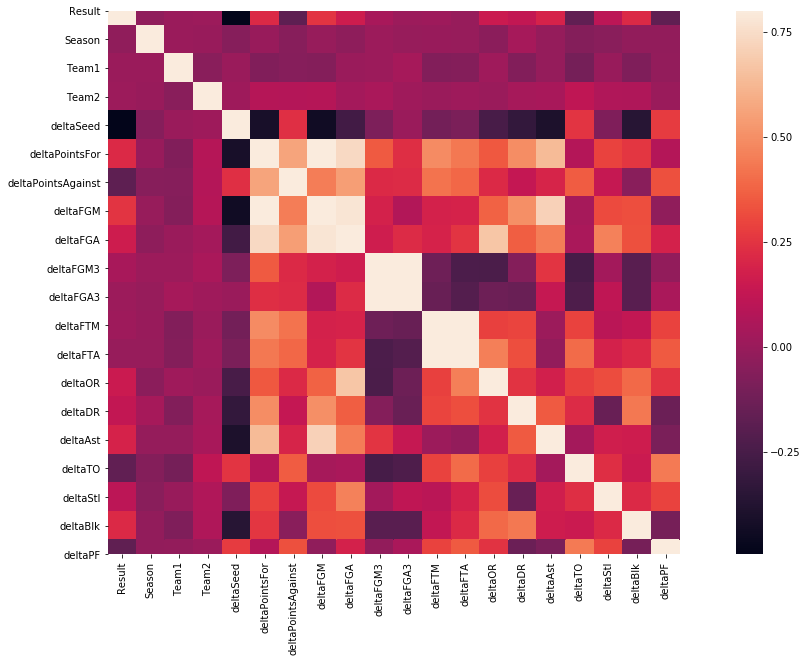

In [33]:
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.heatmap(correlation, vmax=.8, square=True)

What are some things we notice about this plot? Does it make sense? 

One thing that I think is interesting is the strong relationship between assists, and field goals made. 

The obvious ones are the relationship between field goals made and field goals attempted. 

At no point in this process should you be blindly developing a model. Taking a second to check if your results are rational goes a long way. 

Although this is nice, in reality, we are really only interested in one thing here... RESULTS!

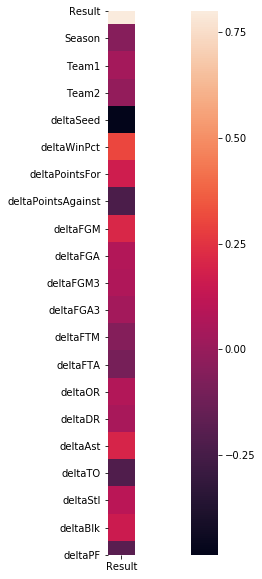

In [41]:
sns.heatmap(correlation[["Result"]], vmax=.8, square=True)

Here you can see that there is not a strong correlation between any of our features and result. It's almost as if this were a difficult machine learning problem with no clear indicator!

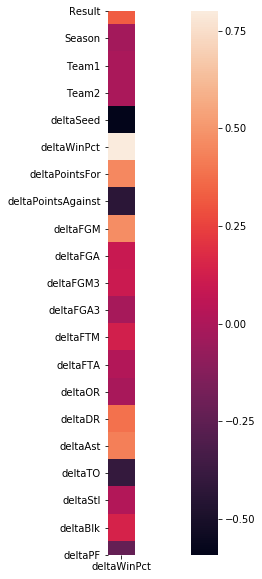

In [44]:
sns.heatmap(correlation[["deltaWinPct"]], vmax=.8, square=True)

## Model Creation

Here we go, the moment you have all been waiting for. Model creation! 

First thing we are going to do is consider define an X and a y. This should look a lot like a simple linear equation, X being an array of Xs. 

In [196]:
training_set.head()

Result  Season  Team1  Team2  deltaSeed  deltaPointsFor  \
0       1    2003   1421   1411          0       -1.593103   
1       1    2003   1112   1436        -15       17.421182   
2       1    2003   1113   1272          3        1.448276   
3       1    2003   1141   1166          5        0.102403   
4       1    2003   1143   1301         -1        2.082759   

   deltaPointsAgainst  deltaFGM  deltaFGA  deltaFGM3  ...  deltaFTM  deltaFTA  \
0            7.614943 -0.354023  1.526437   0.549425  ... -1.434483 -7.135632   
1            7.112069  5.493842  9.852217   1.759852  ...  4.673645  5.448276   
2            3.344828  0.931034 -3.103448  -3.000000  ...  2.586207  3.310345   
3            8.908046 -2.076280 -4.764890  -1.142111  ...  5.397074  5.142111   
4            1.758621  3.011494  5.390805  -1.552874  ... -2.387356 -0.949425   

    deltaOR   deltaDR  deltaAst   deltaTO  deltaStl  deltaBlk   deltaPF  \
0 -0.890805 -1.627586 -1.165517  0.973563  0.635632  0.766667  0.803448   
1  2.213054  1.918719  3.435961  0.716749  1.602217  1.248768  1.853448   
2 -0.379310 -2.655172 -1.068966  0.206897 -2.172414 -0.827586  0.655172   
3 -0.292581  0.094044 -1.197492  4.877743 -1.290491 -0.454545  3.692790   
4  1.508046  2.345977  1.333333 -0.027586 -1.214943 -0.273563 -1.563218   

   deltaWinPct  
0    -0.151724  
1     0.237685  
2    -0.172414  
3    -0.085684  
4     0.124138  

[5 rows x 21 columns]

In [200]:
cols = ['deltaSeed', 'deltaWinPct','deltaPointsFor','deltaPointsAgainst','deltaFGM','deltaFGA','deltaFGM3','deltaFGA3','deltaFTM',
        'deltaFTA','deltaOR','deltaDR','deltaAst','deltaTO','deltaStl','deltaBlk','deltaPF']
X = training_set[cols]
y = training_set['Result']   

## Linear - Ordinary Least Squares

In [201]:
from sklearn import linear_model

In [202]:
linearModel = linear_model.LinearRegression()
linearModel.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [203]:
linearModel.score(X,y)

0.2785633189300727

In [205]:
linearModel.predict(X)

array([0.46896389, 0.96535815, 0.49041676, ..., 0.37660537, 0.57321775,
       0.43072788])

In [208]:
# Xtrain = training_set[training_set['Season'] != year][cols]
# ytrain = training_set[training_set['Season'] != year]['Result']

year = 2018
# logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()

Xtest = training_set[training_set['Season'] == year][cols]
ytest = training_set[training_set['Season'] == year]['Result']

pred = clf.predict(Xtest)

         Current function value: 0.530923
         Iterations: 35


C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [234]:
year = 2013
X_test = training_set[training_set['Season'] == year][cols]
y_test = training_set[training_set['Season'] == year]['Result']

In [235]:
df_results = X_test
df_results['Prediction'] = linearModel.predict(X_test)
df_results['Result'] = y_test
df_results


deltaSeed  deltaWinPct  deltaPointsFor  deltaPointsAgainst  deltaFGM  \
646          0    -0.154412        5.757353            9.369485  2.128676   
647          0     0.035985       -3.632576           -5.524621 -1.032197   
648          0     0.017825       14.278075           12.040998  4.561497   
649          0    -0.044828       -1.364368            0.481609 -0.940230   
650          5     0.018750        3.618750            0.945833  2.602083   
..         ...          ...             ...                 ...       ...   
708          1    -0.009191        4.722426            7.435662  1.490809   
709          1    -0.006629        2.738636            9.240530  1.444129   
710         -8     0.088235        4.117647           -2.735294  1.264706   
711          0    -0.038393       -3.032143           -2.851786 -1.970536   
712         -3     0.071691       -0.816176           -4.966912 -1.803309   

     deltaFGA  deltaFGM3  deltaFGA3  deltaFTM  deltaFTA   deltaOR   deltaDR  \
646  1.931985   0.987132  -0.737132  0.512868 -1.661765 -0.584559  0.371324   
647 -1.219697  -2.480114  -6.849432  0.911932  2.411932  0.214015 -0.208333   
648  2.412656   1.628342   1.915330  3.526738  5.440285  1.787879  0.900178   
649 -2.089655  -0.082759  -1.051724  0.598851  0.555172 -0.375862  1.606897   
650  0.310417   0.643750   1.006250 -2.229167 -2.679167 -2.164583 -1.885417   
..        ...        ...        ...       ...       ...       ...       ...   
708 -0.652574   1.926471   1.476103 -0.185662 -0.873162 -3.961397  0.273897   
709  3.047348  -1.050189  -2.498106  0.900568  0.621212  0.048295 -0.202652   
710  2.558824  -0.764706  -1.941176  2.352941  2.647059  0.470588 -1.411765   
711  0.808929  -1.286607  -1.448214  2.195536  4.100000  3.949107 -0.112500   
712  0.496324  -1.520221  -1.944853  4.310662  6.029412  3.023897 -0.430147   

     deltaAst   deltaTO  deltaStl  deltaBlk   deltaPF  Prediction  Result  
646  0.713235 -1.746324 -1.698529 -1.623162 -0.505515    0.454758       0  
647 -0.348485  1.850379  1.059659  0.819129  3.074811    0.474546       0  
648  3.537433  3.217469 -1.064171 -0.984848  0.580214    0.445433       0  
649 -1.987356  0.575862 -1.445977 -1.911494  3.975862    0.406463       0  
650  1.956250  0.472917  2.595833 -1.172917  1.856250    0.436334       0  
..        ...       ...       ...       ...       ...         ...     ...  
708 -0.312500 -1.957721 -4.204044 -0.454044 -0.016544    0.339074       0  
709 -0.693182 -1.902462 -0.938447 -0.459280 -1.058712    0.373330       1  
710  1.205882 -0.117647  3.264706 -0.235294  0.029412    0.821352       1  
711  0.417857  3.409821  2.854464  3.356250  3.108929    0.534529       0  
712  0.875000  3.457721  4.704044  1.391544  4.672794    0.614756       1  

[67 rows x 19 columns]

In [236]:
-np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()

0.5494633042632471

In [355]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    df_results = X_test
    df_results['Prediction'] = linearModel.predict(X_test)
    df_results['Result'] = y_test
    df_results

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error)

Year: 2003 ,  Error: 0.4083360949260562
Year: 2004 ,  Error: 0.5280568562825172
Year: 2005 ,  Error: 0.38175284993148906
Year: 2006 ,  Error: 0.586967567641824
Year: 2007 ,  Error: 0.4358026459053622
Year: 2008 ,  Error: 0.48558055258719623
Year: 2009 ,  Error: 0.5076094757069609
Year: 2010 ,  Error: 0.5166436231862277
Year: 2011 ,  Error: 0.6337378269223194
Year: 2012 ,  Error: 0.5313508085968297
Year: 2013 ,  Error: 0.5494633042632471
Year: 2014 ,  Error: 0.5829834842751208
Year: 2015 ,  Error: 0.5094896178239411
Year: 2016 ,  Error: 0.6234182714401886
Year: 2017 ,  Error: 0.5350722900301069
Year: 2018 ,  Error: 0.6409933274431148


C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## Linear - Logistic Regression

In [356]:
from sklearn.linear_model import LogisticRegression

In [357]:
logisticModel = linear_model.LogisticRegression()
logisticModel.fit(X,y)

C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [358]:
logisticModel.score(X,y)

0.7165919282511211

In [359]:
logisticModel.predict_proba(X)

array([[0.52790374, 0.47209626],
       [0.07053634, 0.92946366],
       [0.54098165, 0.45901835],
       ...,
       [0.64837933, 0.35162067],
       [0.34711448, 0.65288552],
       [0.61018116, 0.38981884]])

In [374]:
year = 2019
X_test = training_set[training_set['Season'] == year][cols]
y_test = training_set[training_set['Season'] == year]['Result']

df_results = X_test
df_results['Prediction'] = logisticModel.predict_proba(X_test)[:,1]
df_results['Result'] = y_test
df_results

correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
correct = incorrect + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

total = df_results.shape[0]

accuracy = correct/total

df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01

error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

16


In [376]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    df_results = X_test
    df_results['Prediction'] = logisticModel.predict_proba(X_test)[:,1]
    df_results['Result'] = y_test
    df_results

    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = incorrect + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
    df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2003 ,  Error: 0.4051148133431394 Accuracy: 0.578125
Year: 2004 ,  Error: 0.5508230176858275 Accuracy: 0.5625
Year: 2005 ,  Error: 0.34675988390041046 Accuracy: 0.65625
Year: 2006 ,  Error: 0.5946094594037509 Accuracy: 0.625
Year: 2007 ,  Error: 0.4276082032854787 Accuracy: 0.671875
Year: 2008 ,  Error: 0.4479834389829714 Accuracy: 0.6875
Year: 2009 ,  Error: 0.5264399592649617 Accuracy: 0.578125
Year: 2010 ,  Error: 0.5214176424628831 Accuracy: 0.515625
Year: 2011 ,  Error: 0.6545813703724442 Accuracy: 0.6268656716417911
Year: 2012 ,  Error: 0.6778411873349711 Accuracy: 0.5970149253731343
Year: 2013 ,  Error: 0.544362031525971 Accuracy: 0.6268656716417911
Year: 2014 ,  Error: 0.5930213814886208 Accuracy: 0.5522388059701493
Year: 2015 ,  Error: 0.521196059522317 Accuracy: 0.6716417910447762
Year: 2016 ,  Error: 0.6448407334676995 Accuracy: 0.582089552238806
Year: 2017 ,  Error: 0.5446618820206444 Accuracy: 0.582089552238806
Year: 2018 ,  Error: 0.6392930415963122 Accuracy: 0.6417

## Decision Tree Classifier - Train/Test Split

In [388]:
clf2 = tree.DecisionTreeClassifier()
clf2.fit(X,y)
clf2.score(X,y)

1.0

Perfect! We scored 100%!

In [389]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

In [391]:
clf2.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [392]:
clf2.score(X_train, y_train)

1.0

In [394]:
clf2.score(X_test, y_test)

0.5267857142857143

In [395]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    df_results = X_test
    df_results['Prediction'] = clf.predict_proba(X_test)
    df_results['Result'] = y_test
    df_results
    

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error)

AttributeError: predict_proba is not available when  probability=False

## Random Forest Classifier

In [396]:
from sklearn.ensemble import RandomForestClassifier

In [406]:
clf2 = RandomForestClassifier(n_estimators = 10)

In [407]:
clf2.fit(X_train, y_train)
clf2.score(X_train, y_train)

0.9920239282153539

In [408]:
clf2.score(X_test, y_test)

0.921875

In [409]:
clf2.predict_proba(X_test)

array([[0.2, 0.8],
       [0. , 1. ],
       [0.1, 0.9],
       [0.2, 0.8],
       [0.3, 0.7],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.2, 0.8],
       [0.9, 0.1],
       [1. , 0. ],
       [0.6, 0.4],
       [0. , 1. ],
       [0.3, 0.7],
       [1. , 0. ],
       [0.9, 0.1],
       [0.8, 0.2],
       [0.5, 0.5],
       [0.3, 0.7],
       [0.4, 0.6],
       [0.1, 0.9],
       [0.8, 0.2],
       [0. , 1. ],
       [0.1, 0.9],
       [0. , 1. ],
       [0.7, 0.3],
       [0.1, 0.9],
       [0.9, 0.1],
       [0.3, 0.7],
       [0.2, 0.8],
       [1. , 0. ],
       [0.7, 0.3],
       [0.9, 0.1],
       [1. , 0. ],
       [0. , 1. ],
       [0.8, 0.2],
       [1. , 0. ],
       [0. , 1. ],
       [0.7, 0.3],
       [0.2, 0.8],
       [0.1, 0.9],
       [0.8, 0.2],
       [0.4, 0.6],
       [0.2, 0.8],
       [0.9, 0.1],
       [0.7, 0.3],
       [0.6, 0.4],
       [0.1, 0.9],
       [0.8, 0.2],
       [0. , 1. ],
       [0.9, 0.1],
       [0.9, 0.1],
       [0. , 1. ],
       [0.3,

In [410]:
clf2.predict_proba(X_test)[:,0]

array([0.2, 0. , 0.1, 0.2, 0.3, 0.1, 0.9, 0.2, 0.9, 1. , 0.6, 0. , 0.3,
       1. , 0.9, 0.8, 0.5, 0.3, 0.4, 0.1, 0.8, 0. , 0.1, 0. , 0.7, 0.1,
       0.9, 0.3, 0.2, 1. , 0.7, 0.9, 1. , 0. , 0.8, 1. , 0. , 0.7, 0.2,
       0.1, 0.8, 0.4, 0.2, 0.9, 0.7, 0.6, 0.1, 0.8, 0. , 0.9, 0.9, 0. ,
       0.3, 0.3, 1. , 0.2, 0.9, 0.4, 0.4, 0.5, 0.9, 0.1, 0.1, 0.1])

In [412]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    #not sure if this should be :,1 or :,0
    df_results = X_test
    df_results['Prediction'] = clf2.predict_proba(X_test)[:,1]
    df_results['Result'] = y_test
    df_results
    
    df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
    df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01
    
    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = incorrect + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2003 ,  Error: 0.22455049514254752 Accuracy: 0.765625
Year: 2004 ,  Error: 0.27143411729034606 Accuracy: 0.71875
Year: 2005 ,  Error: 0.22147073467527476 Accuracy: 0.78125
Year: 2006 ,  Error: 0.23650451622535115 Accuracy: 0.734375
Year: 2007 ,  Error: 0.23515801870040814 Accuracy: 0.703125
Year: 2008 ,  Error: 0.17898810841284635 Accuracy: 0.78125
Year: 2009 ,  Error: 0.20088953129315146 Accuracy: 0.6875
Year: 2010 ,  Error: 0.18481441426021228 Accuracy: 0.71875
Year: 2011 ,  Error: 0.2120313622593688 Accuracy: 0.7910447761194029
Year: 2012 ,  Error: 0.19529621889099122 Accuracy: 0.7313432835820896
Year: 2013 ,  Error: 0.29018927695295416 Accuracy: 0.835820895522388
Year: 2014 ,  Error: 0.20640993289852388 Accuracy: 0.6268656716417911
Year: 2015 ,  Error: 0.271710514155756 Accuracy: 0.7164179104477612
Year: 2016 ,  Error: 0.31434267244972147 Accuracy: 0.6268656716417911
Year: 2017 ,  Error: 0.21831348067350023 Accuracy: 0.6268656716417911
Year: 2018 ,  Error: 0.3437064363109319 

## Neural Network

In [457]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [458]:
clf3 = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(20,2), random_state=1)

In [459]:
scaler = StandardScaler()

In [460]:
X_train

array([[ 7.98275599e-01, -1.16995979e+00, -1.59499946e+00, ...,
        -3.08512845e-02, -1.18671936e-01, -1.62815843e-01],
       [-2.00640813e+00,  3.26611747e+00,  1.00797208e+00, ...,
         1.08697675e+00,  1.17513707e+00, -2.75554747e-01],
       [ 1.19894470e+00,  2.39538436e-01,  1.15018572e+00, ...,
        -2.02930401e+00, -8.10716009e-01,  9.99882973e-01],
       ...,
       [-3.06260864e-03,  2.31820487e-02, -1.57711327e+00, ...,
        -1.14500335e+00, -2.26645388e-01, -3.44573565e-01],
       [ 1.30493759e-01, -3.15264722e-01, -8.92711421e-01, ...,
        -8.64722629e-01, -1.89490348e+00, -1.08767395e+00],
       [-1.36618977e-01,  2.38941865e-01, -7.21694406e-01, ...,
        -2.64728044e-01, -8.28302294e-01, -1.32991287e-01]])

In [461]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train

array([[ 7.98275599e-01, -1.16995979e+00, -1.59499946e+00, ...,
        -3.08512845e-02, -1.18671936e-01, -1.62815843e-01],
       [-2.00640813e+00,  3.26611747e+00,  1.00797208e+00, ...,
         1.08697675e+00,  1.17513707e+00, -2.75554747e-01],
       [ 1.19894470e+00,  2.39538436e-01,  1.15018572e+00, ...,
        -2.02930401e+00, -8.10716009e-01,  9.99882973e-01],
       ...,
       [-3.06260864e-03,  2.31820487e-02, -1.57711327e+00, ...,
        -1.14500335e+00, -2.26645388e-01, -3.44573565e-01],
       [ 1.30493759e-01, -3.15264722e-01, -8.92711421e-01, ...,
        -8.64722629e-01, -1.89490348e+00, -1.08767395e+00],
       [-1.36618977e-01,  2.38941865e-01, -7.21694406e-01, ...,
        -2.64728044e-01, -8.28302294e-01, -1.32991287e-01]])

In [462]:
clf3.fit(X_train, y_train)
clf3.score(X_train, y_train)

0.9262213359920239

In [463]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    #not sure if this should be :,1 or :,0
    df_results = X_test
    df_results['Prediction'] = clf3.predict_proba(X_test)[:,1]
    df_results['Result'] = y_test
    df_results
    
    df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
    df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01
    
    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = incorrect + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2003 ,  Error: 0.8306074519489639 Accuracy: 0.5625
Year: 2004 ,  Error: 1.1674824547141465 Accuracy: 0.609375
Year: 2005 ,  Error: 0.5950521167911715 Accuracy: 0.640625
Year: 2006 ,  Error: 0.7594138666423279 Accuracy: 0.578125
Year: 2007 ,  Error: 0.6858032549909411 Accuracy: 0.703125
Year: 2008 ,  Error: 0.49315044484283266 Accuracy: 0.65625
Year: 2009 ,  Error: 1.6318573417833562 Accuracy: 0.515625
Year: 2010 ,  Error: 0.28854244798287043 Accuracy: 0.546875
Year: 2011 ,  Error: 1.3192785227028616 Accuracy: 0.5970149253731343
Year: 2012 ,  Error: 1.4661945478480005 Accuracy: 0.582089552238806
Year: 2013 ,  Error: 1.2843916698986402 Accuracy: 0.6417910447761194
Year: 2014 ,  Error: 1.5172735366731114 Accuracy: 0.5223880597014925
Year: 2015 ,  Error: 0.7865923279351655 Accuracy: 0.6716417910447762
Year: 2016 ,  Error: 1.0762040933668584 Accuracy: 0.5671641791044776
Year: 2017 ,  Error: 1.345168210570063 Accuracy: 0.5671641791044776
Year: 2018 ,  Error: 1.5945744221068079 Accuracy

In [464]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_train

array([[ 7.98275599e-01, -1.16995979e+00, -1.59499946e+00, ...,
        -3.08512845e-02, -1.18671936e-01, -1.62815843e-01],
       [-2.00640813e+00,  3.26611747e+00,  1.00797208e+00, ...,
         1.08697675e+00,  1.17513707e+00, -2.75554747e-01],
       [ 1.19894470e+00,  2.39538436e-01,  1.15018572e+00, ...,
        -2.02930401e+00, -8.10716009e-01,  9.99882973e-01],
       ...,
       [-3.06260864e-03,  2.31820487e-02, -1.57711327e+00, ...,
        -1.14500335e+00, -2.26645388e-01, -3.44573565e-01],
       [ 1.30493759e-01, -3.15264722e-01, -8.92711421e-01, ...,
        -8.64722629e-01, -1.89490348e+00, -1.08767395e+00],
       [-1.36618977e-01,  2.38941865e-01, -7.21694406e-01, ...,
        -2.64728044e-01, -8.28302294e-01, -1.32991287e-01]])

## Grid Search CV

In [468]:
parameters = {'solver': ['lbfgs'], 'max_iter': [1000,1500,2000 ], 'alpha': 10.0 ** -np.arange(1, 10, 5), 'hidden_layer_sizes':np.arange(1, 20, 5)}

In [474]:
clf4 = GridSearchCV(MLPClassifier(), parameters, n_jobs=-1)

In [475]:
clf4.fit(X_train, y_train)

C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.001, max_iter=200,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=None, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=-1,
             param_grid={'alpha': array([1.e-01, 1.e-06]),
    

In [476]:
clf4.best_params_

{'alpha': 0.1, 'hidden_layer_sizes': 1, 'max_iter': 1000, 'solver': 'lbfgs'}

In [477]:
for year in range(2003,2019):
    X_test = training_set[training_set['Season'] == year][cols]
    y_test = training_set[training_set['Season'] == year]['Result']

    #not sure if this should be :,1 or :,0
    df_results = X_test
    df_results['Prediction'] = clf4.predict_proba(X_test)[:,1]
    df_results['Result'] = y_test
    df_results
    
    df_results.loc[df_results['Prediction'] > 0.9, 'Prediction']=0.99
    df_results.loc[df_results['Prediction'] < 0.1, 'Prediction']=0.01
    
    correct = df_results.loc[(df_results['Result']==0) & (df_results['Prediction']<0.5)].shape[0]
    correct = incorrect + df_results.loc[(df_results['Result']==1) & (df_results['Prediction']>0.5)].shape[0]

    total = df_results.shape[0]

    accuracy = correct/total

    error = -np.log(1-df_results.loc[df_results['Result'] == 0]['Prediction']).mean()
    print("Year:", year, ","," Error:", error, "Accuracy:", accuracy)

Year: 2003 ,  Error: 0.7490519425941123 Accuracy: 0.546875
Year: 2004 ,  Error: 1.2008450406720113 Accuracy: 0.578125
Year: 2005 ,  Error: 0.6680748508346676 Accuracy: 0.640625
Year: 2006 ,  Error: 1.0967670015924906 Accuracy: 0.59375
Year: 2007 ,  Error: 0.7848733431754021 Accuracy: 0.640625
Year: 2008 ,  Error: 0.7390611849679758 Accuracy: 0.640625
Year: 2009 ,  Error: 1.2321019532857438 Accuracy: 0.5625
Year: 2010 ,  Error: 0.6230581065505213 Accuracy: 0.515625
Year: 2011 ,  Error: 1.416083454161534 Accuracy: 0.6268656716417911
Year: 2012 ,  Error: 1.5245216775506172 Accuracy: 0.582089552238806
Year: 2013 ,  Error: 1.0995128343492484 Accuracy: 0.6268656716417911
Year: 2014 ,  Error: 1.5126203730351857 Accuracy: 0.5074626865671642
Year: 2015 ,  Error: 1.04692645083449 Accuracy: 0.6417910447761194
Year: 2016 ,  Error: 1.3203251780839573 Accuracy: 0.5522388059701493
Year: 2017 ,  Error: 1.0900464207549898 Accuracy: 0.5522388059701493
Year: 2018 ,  Error: 1.5504391060479763 Accuracy: 0.

## Cross Validation

In [478]:
from sklearn.model_selection import train_test_split

In [479]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1)

In [480]:
clf.fit(X_train, y_train)
clf.score(X_train, y_train)

0.7218344965104686

In [481]:
clf.score(X_test,  y_test)

0.6964285714285714

In [482]:
from sklearn.model_selection import StratifiedKFold

In [483]:
kf = StratifiedKFold(n_splits=10)

In [484]:
kf

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [485]:
from sklearn.model_selection import cross_val_score

In [486]:
cross_val_score(clf, X_train, y_train, cv=kf)

array([0.6039604 , 0.72277228, 0.73267327, 0.6       , 0.7       ,
       0.72      , 0.68      , 0.68      , 0.66      , 0.64      ])

In [98]:
clf = svm.SVC(C=.5, gamma="auto")
clf.fit(X,y)
clf.score(X,y)

0.9345291479820628

In [99]:
clf = svm.SVC(C=1, gamma='auto')
clf.fit(X,y)
clf.score(X,y)

1.0

In [487]:
## Maybe Delete This

In [173]:
errs = []
for year2 in range(2003,2019):
    print("Evaluation on tournament year",year2)
#     Xtrain = training_set[training_set['Season'] != year2][cols]
#     ytrain = training_set[training_set['Season'] != year2]['Result']

#     logit_model=sm.Logit(ytrain,Xtrain)
#     result=logit_model.fit()

    X_test = training_set[training_set['Season'] == year2][cols]
    y_test = training_set[training_set['Season'] == year2]['Result']
    
#     pred.loc[(pred >= 0.9999)] = 0.9999
#     pred.loc[(pred <= 0.0001)] = 0.0001
    training_set['prediction'] = linearModel.predict(X_test)
    training_set['prediction'].loc[training_set[training_set['Season'] == year2]['Result'] == 0] = 1 - pred.loc[training_set[training_set['Season'] == year2]['Result'] == 0] 
    err = -np.log(pred).mean()

    errs.append(err)

print("Mean log loss: ",np.mean(errs))



print("Log losses by season")
print("--------------------")
print("year","your score",sep="\t")
years1 = range(2003,2014)
for i in range(len(years1)):
    print(years1[i], "{0:.6f}".format(errs[i]),sep="\t")
    
print("Log losses by season")
print("--------------------")
print("year","your score","your result","winning score",sep="\t")    
years2 = range(2014,2019)
for i in range(len(years2)):
    result = None
    if errs[i+len(years1)] < winner[i]:
        result="Win competition"
    elif errs[i+len(years1)] < top5[i]:
        result="Top 5 score"
    else:
        for j in range(len(topprctvalues)):
            if errs[i+len(years1)] < topprctscores[j][i]:
                result = "Top " + str(topprctvalues[j]) + "%"
                break
        if result is None:
            result = "Worst score on Kaggle"

    print(years2[i], "{0:.6f}".format(errs[i+len(years1)]),result+"\t",winner[i],sep="\t")

Evaluation on tournament year 2003


ValueError: Length of values does not match length of index

In [488]:
clf.summary()

AttributeError: 'MLPClassifier' object has no attribute 'summary'

In [149]:
# ordinary least squares
reg_model = sm.OLS(y,X)
result=reg_model.fit()
print(result.summary2())

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.134    
Dependent Variable:     Result           AIC:                         2266.0272
Date:                   2020-03-05 13:18 BIC:                         2346.2930
No. Observations:       1115             Log-Likelihood:              -1117.0  
Df Model:               16               F-statistic:                 11.76    
Df Residuals:           1099             Prob (F-statistic):          9.48e-29 
R-squared (uncentered): 0.146            Scale:                       0.44051  
---------------------------------------------------------------------------------
                         Coef.    Std.Err.      t      P>|t|     [0.025    0.975]
---------------------------------------------------------------------------------
deltaSeed               -0.0253     0.0040   -6.2903   0.0000   -0.0332   -0.0174
deltaWinPct             -0.5351     0.2655   -2.0158   0

Uh.... what are we looking at? 

Well..... there is a lot going on here. The coefficients tell you how much of an impact each feature has on the model. Look through some of them. Do they make sense?

Win percentage obviously stands out. There is quite a bit of error associated with that term as well though. 

I also look at the R-squared value. This tells you a general fit of the model. 

Lets try another one!

In [118]:
## TODO.... create more models here
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())   

         Current function value: 0.530538
         Iterations: 35
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.234     
Dependent Variable:  Result           AIC:              1215.1002 
Date:                2020-03-03 15:50 BIC:              1295.3660 
No. Observations:    1115             Log-Likelihood:   -591.55   
Df Model:            15               LL-Null:          -771.95   
Df Residuals:        1099             LLR p-value:      1.1541e-67
Converged:           0.0000           Scale:            1.0000    
No. Iterations:      35.0000                                      
------------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------
deltaSeed          -0.1286   0.0148 -8.6781 0.0000 -0.1577 -0.0996
deltaWinPct        -1.7471   0.9629 -1.8144 0.0696 -3.6343  0.1402
deltaPointsFor      0.

C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))
C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\C176616\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= 

Ok, lets give this a shot. We are going to train our model on all of our data EXCEPT the year we want to predict, and then we will predict the given year. Let's start with 2018. 

In [119]:
year = 2018

In [161]:
Xtrain = training_set[training_set['Season'] != year][cols]
ytrain = training_set[training_set['Season'] != year]['Result']

logit_model=sm.Logit(ytrain,Xtrain)
result=logit_model.fit()

Xtest = training_set[training_set['Season'] == year][cols]
ytest = training_set[training_set['Season'] == year]['Result']

pred = result.predict(Xtest)

Optimization terminated successfully.
         Current function value: 0.532176
         Iterations 18


In [162]:
pred

1048    0.573151
1049    0.537493
1050    0.403495
1051    0.476988
1052    0.741602
          ...   
1110    0.469265
1111    0.145598
1112    0.319854
1113    0.622145
1114    0.406304
Length: 67, dtype: float64

Ok, so what did that do? Well, let's see Xtest and pred. 

In [121]:
Xtest.head()

deltaSeed  deltaWinPct  deltaPointsFor  deltaPointsAgainst  deltaFGM  \
981          0     0.109848       -9.759470          -11.943182 -3.294508   
982          0    -0.125000        4.000000            5.312500  1.937500   
983          0    -0.039101      -15.970674          -10.777126 -5.210166   
984          0    -0.074953        7.259962            9.025617 -0.337761   
985          1    -0.097426       -7.365809           -1.779412 -2.862132   

     deltaFGA  deltaFGM3  deltaFGA3  deltaFTM  deltaFTA   deltaOR   deltaDR  \
981 -3.519886  -0.252841  -0.884470 -2.917614 -5.110795  0.297348 -4.030303   
982  3.531250   1.625000   5.000000 -1.500000 -1.062500 -0.031250  3.250000   
983 -5.833822  -3.086999  -6.366569 -2.463343 -3.409580  2.187683  0.010753   
984  1.596774   1.855787   3.561670  6.079696  7.552182 -0.834915  0.398482   
985 -1.387868  -2.367647  -3.042279  0.726103  2.226103  2.654412  0.639706   

     deltaAst   deltaTO  deltaStl  deltaBlk   deltaPF  
981 -0.458333 -2.121212  0.736742 -0.245265 -2.886364  
982  0.843750  0.375000 -1.218750  0.312500 -2.093750  
983 -3.191593  1.866080  0.661779  1.995112 -2.632454  
984 -2.574004 -1.543643  0.910816  0.521822 -1.748577  
985 -3.970588  2.209559  0.661765  3.189338  3.312500

In [122]:
pred

981     0.686248
982     0.460277
983     0.504945
984     0.392743
985     0.416562
          ...   
1043    0.394735
1044    0.287884
1045    0.180661
1046    0.346341
1047    0.267505
Length: 67, dtype: float64

What this is saying, is that for game 201, 202... etc, given all of this data, 0.69, 0.54. Those are predicted values. Since our values range for 0 to 1, this can be treated as a percentage chance to win! 

Funny enough, we know who won all of those games! So we can compare our predictions with the actual winners and quantify how good the model is. 

In [154]:
pred.loc[training_set[training_set['Season'] == year]['Result'] == 0] = 1 - pred.loc[training_set[training_set['Season'] == year]['Result'] == 0] 
err = -np.log(pred).mean()
err

0.9439347367894466

In [126]:
# Stats from previous competitions

winner=[0.52951,0.438933,0.481309,0.438575,0.531942]
top5=[0.54772,0.453872,0.519706,0.461073,0.549876]
topprctvalues=[5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
topprctscores=[[0.55620,0.465207,0.536976,0.472893,0.576667,], # 5%
               [0.56035,0.469617,0.543597,0.479488,0.581399,], # 10%
               [0.56411,0.474137,0.550067,0.486432,0.586220,], # 15%
               [0.56958,0.478107,0.556954,0.491655,0.590554,], # 20%
               [0.57177,0.481519,0.563566,0.495595,0.594101,], # 25%
               [0.57495,0.486253,0.569619,0.500194,0.597493,], # 30%
               [0.57946,0.490536,0.577442,0.505821,0.601023,], # 35%
               [0.58676,0.496779,0.582541,0.511053,0.603920,], # 40%
               [0.59418,0.500862,0.585897,0.515844,0.608200,], # 45%
               [0.59921,0.508830,0.589459,0.522958,0.613297,], # 50%
               [0.60593,0.516735,0.594342,0.528533,0.621995,], # 55%
               [0.61288,0.523082,0.607036,0.534732,0.631227,], # 60%
               [0.61915,0.528358,0.627708,0.541466,0.645569,], # 65%
               [0.62780,0.539478,0.646980,0.556034,0.664821,], # 70%
               [0.65659,0.552809,0.682279,0.576019,0.688618,], # 75%
               [0.67932,0.574223,0.764058,0.605337,0.705595,], # 80%
               [0.73514,0.625012,0.865465,0.643514,0.776256,], # 85%
               [0.98764,0.692878,0.865465,0.693147,1.071796], # 90%
               [1.59656,0.882637,1.045207,0.897480,1.204277,], # 95%
               [19.18820,11.513103,9.092529,12.609623,18.092158,],] # 100%

In [132]:
errs = []
for year2 in range(2003,2019):
    print("Evaluation on tournament year",year)
    Xtrain = training_set[training_set['Season'] != year2][cols]
    ytrain = training_set[training_set['Season'] != year2]['Result']

    logit_model=sm.Logit(ytrain,Xtrain)
    result=logit_model.fit()

    Xtest = training_set[training_set['Season'] == year2][cols]
    ytest = training_set[training_set['Season'] == year2]['Result']
    
    pred.loc[(pred >= 0.9999)] = 0.9999
    pred.loc[(pred <= 0.0001)] = 0.0001

    pred.loc[training_set[training_set['Season'] == year2]['Result'] == 0] = 1 - pred.loc[training_set[training_set['Season'] == year2]['Result'] == 0] 
    err = -np.log(pred).mean()

    errs.append(err)

print("Mean log loss: ",np.mean(errs))



print("Log losses by season")
print("--------------------")
print("year","your score",sep="\t")
years1 = range(2003,2014)
for i in range(len(years1)):
    print(years1[i], "{0:.6f}".format(errs[i]),sep="\t")
    
print("Log losses by season")
print("--------------------")
print("year","your score","your result","winning score",sep="\t")    
years2 = range(2014,2019)
for i in range(len(years2)):
    result = None
    if errs[i+len(years1)] < winner[i]:
        result="Win competition"
    elif errs[i+len(years1)] < top5[i]:
        result="Top 5 score"
    else:
        for j in range(len(topprctvalues)):
            if errs[i+len(years1)] < topprctscores[j][i]:
                result = "Top " + str(topprctvalues[j]) + "%"
                break
        if result is None:
            result = "Worst score on Kaggle"

    print(years2[i], "{0:.6f}".format(errs[i+len(years1)]),result+"\t",winner[i],sep="\t")

NameError: name 'year' is not defined

Cross Validation here

In [80]:
year

2018

In [85]:
training_set.head()

Result  Season  Team1  Team2  deltaSeed  deltaWinPct  deltaPointsFor  \
0       0    2015   1264   1214          0     0.108902        2.723485   
1       1    2015   1279   1140          0    -0.093750       -9.218750   
2       0    2015   1129   1173          0    -0.015640        1.658847   
3       0    2015   1316   1352          0     0.069404        4.935484   
4       0    2015   1411   1112         13    -0.264706       -8.264706   

   deltaPointsAgainst  deltaFGM  deltaFGA  ...  deltaFGA3  deltaFTM  deltaFTA  \
0           -0.500000  0.088068 -3.282197  ...   0.582386  1.682765  0.946970   
1           -5.437500 -2.562500 -1.250000  ...  -2.250000 -2.343750 -3.281250   
2            0.026393  1.466276  4.263930  ...   3.924731 -3.528837 -6.360704   
3            0.788856  0.503421 -0.033236  ...   6.117302  1.612903  1.845552   
4            8.823529 -3.352941 -1.941176  ...   2.470588 -1.794118 -1.264706   

    deltaOR   deltaDR  deltaAst   deltaTO  deltaStl  deltaBlk   deltaPF  
0 -1.836174 -3.254735  3.300189  0.287879  1.427083 -1.309659  1.360795  
1  0.468750 -0.687500 -3.437500 -0.218750 -0.531250  0.812500 -0.968750  
2  1.091887 -0.088954 -2.108504 -1.259042 -1.001955 -0.222874  1.316716  
3 -0.908113  1.741935  1.176931 -1.564027 -2.448680  0.996090 -1.964809  
4  0.529412 -3.235294 -3.323529  1.882353 -1.029412 -0.470588 -0.558824  

[5 rows x 21 columns]

In [128]:
# Run cross validation on model against tournaments in 2003-2018.  For the tournaments since 2014, the winning score
# from the Kaggle tournament is displayed

# TODO: Choose some columns to build the logistic regression models
cols = ['deltaWinPct', 'deltaPointsAgainst']

# TODO: Adjust winning probabilities by this percent for selected teams, based on your
biases = {
    '1163':1.2, # U Conn
    '1181':1.2, # Duke 
    '1437':1.2, # Villanova
    '1314':1.2, # UNC
}

errs = []
for year in range(2003,2019):
    print(year)
    print("Evaluation on tournament year",year)
    Xtrain = training_set[training_set['Season'] != year][cols]
    ytrain = training_set[training_set['Season'] != year]['Result']

    logit_model=sm.Logit(ytrain,Xtrain)
    result=logit_model.fit()

    Xtest = training_set[training_set['Season'] == year][cols]
    ytest = training_set[training_set['Season'] == year]['Result']
    
    pred = result.predict(Xtest)
    for bias in biases:
        pred.loc[(training_set['Season'] == year) & (training_set['Team1'] == int(bias))] = pred.loc[(training_set['Season'] == year) & (training_set['Team1'] == int(bias))] * biases[bias] 
        pred.loc[(training_set['Season'] == year) & (training_set['Team2'] == int(bias))] = pred.loc[(training_set['Season'] == year) & (training_set['Team2'] == int(bias))] / biases[bias] 
    
    pred.loc[(pred >= 0.9999)] = 0.9999
    pred.loc[(pred <= 0.0001)] = 0.0001

    pred.loc[training_set[training_set['Season'] == year]['Result'] == 0] = 1 - pred.loc[training_set[training_set['Season'] == year]['Result'] == 0] 
    err = -np.log(pred).mean()

    errs.append(err)

print("Mean log loss: ",np.mean(errs))



print("Log losses by season")
print("--------------------")
print("year","your score",sep="\t")
years1 = range(2003,2014)
for i in range(len(years1)):
    print(years1[i], "{0:.6f}".format(errs[i]),sep="\t")
    
print("Log losses by season")
print("--------------------")
print("year","your score","your result","winning score",sep="\t")    
years2 = range(2014,2019)
for i in range(len(years2)):
    result = None
    if errs[i+len(years1)] < winner[i]:
        result="Win competition"
    elif errs[i+len(years1)] < top5[i]:
        result="Top 5 score"
    else:
        for j in range(len(topprctvalues)):
            if errs[i+len(years1)] < topprctscores[j][i]:
                result = "Top " + str(topprctvalues[j]) + "%"
                break
        if result is None:
            result = "Worst score on Kaggle"

    print(years2[i], "{0:.6f}".format(errs[i+len(years1)]),result+"\t",winner[i],sep="\t")

2003
Evaluation on tournament year 2003
Optimization terminated successfully.
         Current function value: 0.622756
         Iterations 5
2004
Evaluation on tournament year 2004
Optimization terminated successfully.
         Current function value: 0.620744
         Iterations 5
2005
Evaluation on tournament year 2005
Optimization terminated successfully.
         Current function value: 0.627135
         Iterations 5
2006
Evaluation on tournament year 2006
Optimization terminated successfully.
         Current function value: 0.625783
         Iterations 5
2007
Evaluation on tournament year 2007
Optimization terminated successfully.
         Current function value: 0.629864
         Iterations 5
2008
Evaluation on tournament year 2008
Optimization terminated successfully.
         Current function value: 0.630568
         Iterations 5
2009
Evaluation on tournament year 2009
Optimization terminated successfully.
         Current function value: 0.626288
         Iterations 5
2010
E

One last thing. Just for fun, say I just really like a specific team. Let's go ahead and build in some bias just for fun. This is in reality a terrible idea. All machine learning should be done blind, but if you go to //data//Teams.csv, you can see the list of Team IDs and the correlating Team Names. 

Yes, this is considered cheating :)

In [ ]:
# Build the final model
cols = ['deltaWinPct', 'deltaPointsAgainst']

# TODO: Adjust winning probabilities by this percent for selected teams, based on your
biases = {
    '1163':1.2, # U Conn
    '1181':1.2, # Duke 
    '1437':1.2, # Villanova
    '1314':1.2, # UNC
}

In [130]:
cols

['PointsFor',
 'PointsAgainst',
 'FGM',
 'FGA',
 'FGM3',
 'FGA3',
 'FTM',
 'FTA',
 'OR',
 'DR',
 'Ast',
 'TO',
 'Stl',
 'Blk',
 'PF']

Ok, so now we have built a model and cross validated it across every tournament year. The last thing for us to do is to 

In [179]:
## Create a submission file
#sub = pd.read_csv('../input/SampleSubmissionStage1.csv')
sub = pd.read_csv(cwd + '/data/MSampleSubmissionStage1_2020.csv')

# Create predictor attributes (as above for the CV)
sub['Season'], sub['Team1'], sub['Team2'] = sub['ID'].str.split('_').str
sub[['Season', 'Team1', 'Team2']] = sub[['Season', 'Team1', 'Team2']].apply(pd.to_numeric)

sub['deltaSeed'] = sub.apply(delta_seed,axis=1)
# sub['deltaMO'] = sub.apply(delta_ord,axis=1)
sub['deltaWinPct'] = sub.apply(delta_winPct,axis=1)
cols = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']

for col in cols:
    print("Processing",col)
    sub['delta' + col] = sub.apply(delta_stat,args=(col,),axis=1)
    
cols = ['deltaWinPct', 'deltaPointsAgainst', 'deltaAst']

Xtrain = training_set[cols]
ytrain = training_set['Result']

logit_model=sm.Logit(ytrain,Xtrain)
result=logit_model.fit()

# Make your predictions
Xtest = sub[cols]
pred = result.predict(Xtest)

# Bias results based on team preferences
for bias in biases:
    pred.loc[sub['Team1'] == int(bias)] = pred.loc[sub['Team1'] == int(bias)] * biases[bias] 
    pred.loc[sub['Team2'] == int(bias)] = pred.loc[sub['Team2'] == int(bias)] / biases[bias] 
    
pred.loc[(pred >= 0.9999)] = 0.9999
pred.loc[(pred <= 0.0001)] = 0.0001

# Create Submission file
sub['Pred'] = pred
sub[['ID', 'Pred']].to_csv('submission.csv', index=False)

Processing PointsFor
Processing PointsAgainst
Processing FGM
Processing FGA
Processing FGM3
Processing FGA3
Processing FTM
Processing FTA
Processing OR
Processing DR
Processing Ast
Processing TO
Processing Stl
Processing Blk
Processing PF
Optimization terminated successfully.
         Current function value: 0.620515
         Iterations 5


In [134]:
sub[['ID', 'Pred']]

ID      Pred
0      2015_1107_1112  0.291137
1      2015_1107_1116  0.539806
2      2015_1107_1124  0.541594
3      2015_1107_1125  0.650091
4      2015_1107_1129  0.514887
...               ...       ...
11385  2019_1449_1459  0.386610
11386  2019_1449_1463  0.574484
11387  2019_1458_1459  0.321347
11388  2019_1458_1463  0.503541
11389  2019_1459_1463  0.681735

[11390 rows x 2 columns]

In [131]:
Xtrain = training_set[cols]

KeyError: "None of [Index(['PointsFor', 'PointsAgainst', 'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM',\n       'FTA', 'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'],\n      dtype='object')] are in the [columns]"

In [136]:
## Create a submission file
#sub = pd.read_csv('../input/SampleSubmissionStage1.csv')
sub = pd.read_csv(cwd + '/data/MSampleSubmissionStage1_2020.csv')

# Create predictor attributes (as above for the CV)
sub['Season'], sub['Team1'], sub['Team2'] = sub['ID'].str.split('_').str
sub[['Season', 'Team1', 'Team2']] = sub[['Season', 'Team1', 'Team2']].apply(pd.to_numeric)

sub['deltaSeed'] = sub.apply(delta_seed,axis=1)
# sub['deltaMO'] = sub.apply(delta_ord,axis=1)
sub['deltaWinPct'] = sub.apply(delta_winPct,axis=1)
# cols = ['PointsFor','PointsAgainst','FGM','FGA','FGM3','FGA3','FTM','FTA','OR','DR','Ast','TO','Stl','Blk','PF']
cols = ['PointsAgainst']
for col in cols:
    print("Processing",col)
    sub['delta' + col] = sub.apply(delta_stat,args=(col,),axis=1)
    
cols = ['deltaWinPct', 'deltaPointsAgainst']

Xtrain = training_set[cols]
ytrain = training_set['Result']

logit_model=sm.Logit(ytrain,Xtrain)
result=logit_model.fit()

# Make your predictions
Xtest = sub[cols]
pred = result.predict(Xtest)

# Bias results based on team preferences
for bias in biases:
    pred.loc[sub['Team1'] == int(bias)] = pred.loc[sub['Team1'] == int(bias)] * biases[bias] 
    pred.loc[sub['Team2'] == int(bias)] = pred.loc[sub['Team2'] == int(bias)] / biases[bias] 
    
pred.loc[(pred >= 0.9999)] = 0.9999
pred.loc[(pred <= 0.0001)] = 0.0001

# Create Submission file
sub['Pred'] = pred
# sub[['ID', 'Pred']].to_csv('submission.csv', index=False)

Processing PointsAgainst
Optimization terminated successfully.
         Current function value: 0.625516
         Iterations 5


# Build bracket

## Define Constants

In [48]:
__version__ = '0.2.0'

ID = 'id'
PRED = 'pred'
SEASON = 'season'
TEAM = 'teamname'

## Define Classes

In [49]:
class extNode(Node):
    def __init__(self, value, left=None, right=None, parent=None):
        Node.__init__(self, value, left=left, right=right)
        if parent is not None and isinstance(parent, extNode):
            self.__setattr__('parent', parent)
        else:
            self.__setattr__('parent', None)

    def __setattr__(self, name, value):
        # Magically set the parent to self when a child is created
        if (name in ['left', 'right']
                and value is not None
                and isinstance(value, extNode)):
            value.parent = self
        object.__setattr__(self, name, value)

In [177]:
# True for fixed, False for Random
fixedRandom = True

In [ ]:
year=2019

## Define Functions

In [180]:
import os
#import pkg_resources

from binarytree import Node
# import matplotlib.pyplot as plt # for notebook usage
# import numpy as np # for notebook usage
import pandas as pd
from PIL import Image, ImageDraw

cwd = os.getcwd()

slot_coordinates = {
    2019: {1: (372, 32),# First four
         2: (372, 50),
         3: (30, 328),
         4: (30, 346),
         5: (695, 325),
         6: (695, 343),
         7: (370, 642),
         8: (370, 659),
         9:  (30, 532),# W1
         10: (30, 514),
         11: (30, 567),
         12: (30, 550),
         13: (30, 604),
         14: (30, 586),
         15: (30, 640),
         16: (30, 622),
         17: (30, 496),
         18: (30, 478),
         19: (30, 460),
         20: (30, 442),
         21: (30, 424),
         22: (30, 406),
         23: (30, 388),
         24: (30, 370),
         25: (30, 199),# X1
         26: (30, 182),
         27: (30, 236),
         28: (30, 218),
         29: (30, 272),
         30: (30, 254),
         31: (30, 308),
         32: (30, 290),
         33: (30, 164),
         34: (30, 146),
         35: (30, 128),
         36: (30, 110),
         37: (30, 92),
         38: (30, 74),
         39: (30, 55),
         40: (30, 38),
         41: (815, 532),# Y1
         42: (815, 514),
         43: (815, 567),
         44: (815, 550),
         45: (815, 604),
         46: (815, 586),
         47: (815, 640),
         48: (815, 622),
         49: (815, 496),
         50: (815, 478),
         51: (815, 460),
         52: (815, 442),
         53: (815, 424),
         54: (815, 406),
         55: (815, 388),
         56: (815, 370),
         57: (815, 199),# Z1
         58: (815, 182),
         59: (815, 236),
         60: (815, 218),
         61: (815, 272),
         62: (815, 254),
         63: (815, 308),
         64: (815, 290),
         65: (815, 164),
         66: (815, 146),
         67: (815, 128),
         68: (815, 110),
         69: (815, 92),
         70: (815, 74),
         71: (815, 55),
         72: (815, 38),
         73: (155, 523),# W2
         74: (155, 559),
         75: (155, 595),
         76: (155, 631),
         77: (155, 487),
         78: (155, 451),
         79: (155, 415),
         80: (155, 379),
         81: (155, 191),# X2
         82: (155, 227),
         83: (155, 263),
         84: (155, 299),
         85: (155, 155),
         86: (155, 119),
         87: (155, 83),
         88: (155, 47),
         89: (735, 523),# Y2
         90: (735, 559),
         91: (735, 595),
         92: (735, 631),
         93: (735, 487),
         94: (735, 451),
         95: (735, 415),
         96: (735, 379),
         97: (735, 191),# Z2
         98: (735, 227),
         99: (735, 263),
         100: (735, 299),
         101: (735, 155),
         102: (735, 119),
         103: (735, 83),
         104: (735, 47),
         105: (232, 541),# W3
         106: (232, 613),
         107: (232, 469),
         108: (232, 397),
         109: (232, 209),# X3
         110: (232, 281),
         111: (232, 137),
         112: (232, 65),
         113: (668, 541),# Y3
         114: (668, 613),
         115: (668, 469),
         116: (668, 397),
         117: (668, 209),# Z3
         118: (668, 281),
         119: (668, 137),
         120: (668, 65),
         121: (298, 576),# W4
         122: (298, 432),
         123: (298, 244),# X4
         124: (298, 100),
         125: (601, 576),# Y4
         126: (601, 432),
         127: (601, 244),# Z4
         128: (601, 100),
         129: (358, 504),# W5
         130: (358, 172),# X5
         131: (540, 504),# Y5
         132: (540, 172),# Z5
         133: (420, 457),# WX6
         134: (435, 219),# YZ6
         135: (435, 339)# CH
    }
}

class extNode(Node):
    def __init__(self, value, left=None, right=None, parent=None):
        Node.__init__(self, value, left=left, right=right)
        if parent is not None and isinstance(parent, extNode):
            self.__setattr__('parent', parent)
        else:
            self.__setattr__('parent', None)

    def __setattr__(self, name, value):
        # Magically set the parent to self when a child is created
        if (name in ['left', 'right']
                and value is not None
                and isinstance(value, extNode)):
            value.parent = self
        object.__setattr__(self, name, value)

def clean_col_names(df):
    return df.rename(columns={col: col.lower().replace('_', '') for col in df.columns})

def get_team_id(seedMap):
        return (seedMap, df[df['seed'] == seed_slot_map[seedMap]]['teamid'].values[0])

def get_team_ids_and_gid(slot1, slot2):
    team1 = get_team_id(slot1)
    team2 = get_team_id(slot2)
    if team2[1] < team1[1]:
        temp = team1
        team1 = team2
        team2 = temp
    gid = '{season}_{t1}_{t2}'.format(season=year, t1=team1[1], t2=team2[1])
    return team1, team2, gid

outputPath= cwd + '\\output.png'
teamsPath=cwd + '\\data\\Teams.csv'
seedsPath=cwd + '\\data\\2019TourneySeeds.csv'
slotsPath=cwd + '\\data\\MNCAATourneySlots.csv'
submissionPath=cwd + '\\submission.csv'
resultsPath=None


submit = clean_col_names(pd.read_csv(submissionPath))

teams_df = clean_col_names(pd.read_csv(teamsPath))
seeds_df = clean_col_names(pd.read_csv(seedsPath))
slots_df = clean_col_names(pd.read_csv(slotsPath))

df = seeds_df.merge(teams_df, left_on='teamid', right_on='teamid')

df = df.drop(['firstd1season','lastd1season'], axis=1)

s = slots_df[slots_df['season'] == year]
seed_slot_map = {0: 'R6CH'}
bkt = extNode(0)

counter = 1
current_nodes = [bkt]
current_id = -1
current_index = 0

while current_nodes:
    next_nodes = []
    current_index = 0
    while current_index < len(current_nodes):
        node = current_nodes[current_index]
        if len(s[s['slot'] == seed_slot_map[node.value]].index) > 0:
            node.left = extNode(counter)
            node.right = extNode(counter + 1)
            seed_slot_map[counter] = s[s['slot'] == seed_slot_map[node.value]].values[0][2]
            seed_slot_map[counter + 1] = s[s['slot'] == seed_slot_map[node.value]].values[0][3]
            next_nodes.append(node.left)
            next_nodes.append(node.right)
            counter += 2
        current_index += 1
        current_id += 1
    current_nodes = next_nodes
    
# Solve bracket using predictions
# Also create a map with slot, seed, game_id, pred
    
results_df = pd.DataFrame({"id": [], "pred": []})
    
pred_map = {}

#Straight Winner
if fixedRandom == True:
    for level in list(reversed(bkt.levels)):
    #     print(level)
        for ix, node in enumerate(level[0: len(level) // 2]):
    #         print(node)
            team1, team2, gid = get_team_ids_and_gid(level[ix * 2].value, level[ix * 2 + 1].value)
            print(gid)
            pred = submit[submit['id'] == gid]['pred'].values[0]
            if gid in list(results_df.id):
                game_outcome = results_df[results_df[ID] == gid][PRED].values[0]

                team = team1 if game_outcome == 1 else team2
                if (game_outcome == 1 and pred > 0.5):
                    # outcome agress with prediction, team1 wins
                    pred_label = pred
                elif (game_outcome == 0 and pred > 0.5):
                    # outcome different than prediction, team2 wins
                    pred_label = 1 - pred
                elif (game_outcome == 0 and pred <= 0.5):
                    # outcome agrees with prediction, team2 wins
                    pred_label = 1 - pred
                elif (game_outcome == 1 and pred <= 0.5):
                    # outcome different than prediction, team2 wins
                    pred_label = pred
                else:
                    raise ValueError("wat")

            elif pred >= 0.5:
                team = team1
                pred_label = pred
            else:
                team = team2
                pred_label = 1 - pred

            level[ix * 2].parent.value = team[0]
            pred_map[gid] = (team[0], seed_slot_map[team[0]], pred_label)
            
    slotdata = []
    for ix, key in enumerate([b for a in bkt.levels for b in a]):
        xy = slot_coordinates[2019][max(slot_coordinates[2019].keys()) - ix]
        pred = ''
        gid = ''
        if key.parent is not None:
            team1, team2, gid = get_team_ids_and_gid(key.parent.left.value, key.parent.right.value)
        if gid != '' and pred_map[gid][1] == seed_slot_map[key.value]:
            pred = "{:.2f}%".format(pred_map[gid][2] * 100)
        st = '{seed} {team} {pred}'.format(
            seed=seed_slot_map[key.value],
            team=df[df['seed'] == seed_slot_map[key.value]]['teamname'].values[0],
            pred=pred
        )
        slotdata.append((xy, st))
        
  
# Random Weighted Winner
elif fixedRandom == False:
    print('false')
    for level in list(reversed(bkt.levels)):
    #     print(level)
        for ix, node in enumerate(level[0: len(level) // 2]):
    #         print(node)
            team1, team2, gid = get_team_ids_and_gid(level[ix * 2].value, level[ix * 2 + 1].value)
            print(gid)
            pred = submit[submit['id'] == gid]['pred'].values[0]
                        
            rng = np.random.rand(1)[0]
            print(rng)
            if gid in list(results_df.id):
                game_outcome = results_df[results_df[ID] == gid][PRED].values[0]
                print("gameoutcome" + game_outcome)
                team = team1 if game_outcome == 1 else team2

                if (game_outcome == 1 and pred < rng):
                    # outcome agress with prediction, team1 wins
                    pred_label = pred + rng
                    print("a")
                elif (game_outcome == 0 and pred < rng):
                    # outcome different than prediction, team2 wins
                    pred_label = 1 - pred 
                    print("b")
                elif (game_outcome == 0 and pred >= rng):
                    # outcome agrees with prediction, team2 wins
                    pred_label = 1 - pred + rng
                    print("c")
                elif (game_outcome == 1 and pred >= rng):
                    # outcome different than prediction, team2 wins
                    print("d")
                    pred_label = pred + rng
                else:
                    raise ValueError("wat")

            elif pred >= rng:
                team = team1
                pred_label = pred
                print('winner')
            else:
                team = team2
                print("e")
                pred_label = 1 - pred
            
            pred_label = pred_label
            rng_label = rng
            level[ix * 2].parent.value = team[0]
            pred_map[gid] = (team[0], seed_slot_map[team[0]], pred_label, rng_label)
        
        
###################
    slotdata = []
    for ix, key in enumerate([b for a in bkt.levels for b in a]):
        xy = slot_coordinates[2019][max(slot_coordinates[2019].keys()) - ix]
        pred = ''
        gid = ''
        if key.parent is not None:
            team1, team2, gid = get_team_ids_and_gid(key.parent.left.value, key.parent.right.value)
        if gid != '' and pred_map[gid][1] == seed_slot_map[key.value]:
            pred = "{:.2f}%".format(pred_map[gid][2] * 100)
            rng = "{:.4f}".format(pred_map[gid][3] * 100)
        st = '{seed} {team} {pred} {rng}'.format(
            seed=seed_slot_map[key.value],
            team=df[df['seed'] == seed_slot_map[key.value]]['teamname'].values[0],
            pred=pred,
            rng=rng
        )
        slotdata.append((xy, st))

# Create bracket image
# relevant:
# https://stackoverflow.com/questions/26649716/how-to-show-pil-image-in-ipython-notebook
#emptyBracketPath = pkg_resources.resource_filename(2017.jpg)
img = Image.open('2017.jpg')
draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
# draw.text((x, y),"Sample Text",(r,g,b))
for slot in slotdata:
    draw.text(slot[0], str(slot[1]), (0, 0, 0))

# dpi = 72
# margin = 0.05  # (5% of the width/height of the figure...)
# xpixels, ypixels = 940, 700

# Make a figure big enough to accomodate an axis of xpixels by ypixels
# as well as the ticklabels, etc...
# figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi
# fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
# ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

# ax.imshow(np.asarray(img))
# plt.show() # for in notebook
img.save(outputPath)

               id      pred
0  2015_1107_1112  0.241805
1  2015_1107_1116  0.442358
2  2015_1107_1124  0.439109
3  2015_1107_1125  0.561356
4  2015_1107_1129  0.484961
2019_1295_1300
2019_1125_1396
2019_1192_1341
2019_1113_1385
2019_1181_1300
2019_1416_1433
2019_1387_1439
2019_1251_1280
2019_1133_1277
2019_1257_1278
2019_1261_1463
2019_1125_1268
2019_1211_1341
2019_1124_1393
2019_1199_1436
2019_1266_1293
2019_1276_1285
2019_1196_1305
2019_1297_1403
2019_1113_1138
2019_1233_1314
2019_1429_1449
2019_1242_1318
2019_1120_1308
2019_1101_1246
2019_1371_1459
2019_1209_1222
2019_1235_1326
2019_1205_1438
2019_1279_1328
2019_1243_1414
2019_1332_1458
2019_1159_1397
2019_1153_1234
2019_1330_1345
2019_1388_1437
2019_1181_1433
2019_1251_1439
2019_1277_1278
2019_1125_1463
2019_1124_1211
2019_1293_1436
2019_1276_1305
2019_1138_1403
2019_1314_1429
2019_1242_1308
2019_1246_1459
2019_1222_1235
2019_1279_1438
2019_1414_1458
2019_1153_1397
2019_1330_1437
2019_1181_1251
2019_1125_1277
2019_1211_1293
2019_11

In [169]:
game_outcome = results_df[results_df['id'] == 2019_1330_1437]['pred']
game_outcome

Series([], Name: pred, dtype: float64)

In [171]:
results_df.head()

Empty DataFrame
Columns: [id, pred]
Index: []

In [141]:
%matplotlib qt
dpi = 300
margin = 0.05  # (5% of the width/height of the figure...)
xpixels, ypixels = 940, 700

# Make a figure big enough to accomodate an axis of xpixels by ypixels
# as well as the ticklabels, etc...
figsize = (1 + margin) * ypixels / dpi, (1 + margin) * xpixels / dpi
fig = plt.figure(figsize=figsize, dpi=dpi)
# Make the axis the right size...
ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

ax.imshow(np.asarray(img))
plt.show() # for in notebook

In [194]:
import matplotlib.pyplot as plt

In [ ]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

for name, model in models:
kfold = model_selection.KFold(n_splits=4, random_state=1)
cv_results = model_selection.cross_val_score(model, X_train, y_train, cv
results.append(cv_results)
names.append(name)
msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
print(msg)